In [120]:
import numpy as np
import random as random
import matplotlib.pyplot as plt
import time
import pandas as pd
import multiprocessing
import itertools
from scipy.spatial import distance
np.set_printoptions(threshold=np.nan)

In [121]:
#Import Data
farmData = pd.read_csv('FarmData2001', 
                       names = ["County Number", "Parish Number", "Holding Number", "X Coordinate", "Y Coordinate", "Farm Area", 
                                "Number of Cattle", "Number of Pigs", "Number of Sheep", "Number of Goats", "Number of other Animals"], delim_whitespace=True)
cumbData = farmData[farmData['County Number'] == 10]
#cumbData = farmData
cumbData = cumbData.reset_index(drop=True)
xCumb = cumbData['X Coordinate']/100000
yCumb = cumbData['Y Coordinate']/100000
xmax = np.max(xCumb)
xmin = np.min(xCumb)
ymax = np.max(yCumb)
ymin = np.min(yCumb)
sizex = xmax-xmin
sizey = ymax-ymin
cattleFrame = cumbData['Number of Cattle']
sheepFrame = cumbData['Number of Sheep']
xcoord = xCumb - xmin #Shift to start from (0, 0)
ycoord = yCumb - ymin #Shift to start from (0, 0)
N=np.size(xcoord)

In [127]:
#Calculate Euclidean distances
xinput = xcoord.values
yinput = ycoord.values
print(np.shape(xinput))
print(np.shape(yinput))
joinedinput = np.column_stack((xinput, yinput))
print(np.shape(joinedinput))
dist = distance.cdist(joinedinput, joinedinput, 'euclidean')
print(np.shape(dist))

(10615,)
(10615,)
(10615, 2)
(10615, 10615)


In [128]:
#Parameter values
        
psi = 0.00657
nu = 1.99*(10**(-7))
xi = 2.65
zeta = 1.80
chi = 0.403
s = np.random.negative_binomial(50, 50/55, N) #Draw latent periods
r = np.random.negative_binomial(30, 30/39, N) #Draw infectious periods

t = 0
A = np.zeros(shape=(N,4))
output = np.zeros(shape=(N,6))

In [129]:
#Calculate distance kernel
cattle = abs(cattleFrame.values)
sheep = abs(sheepFrame.values)
K = psi/(psi**2 + dist**2)

K[np.where(dist > 0.2)] = 0


beta1 = np.zeros(N)
beta1 = nu*(xi*(cattle)**chi + (sheep)**chi)

In [130]:
#Choose initial case

initial1 = random.randint(0,N)
initial2=initial1+1
initial3=initial2+1
initial4=initial3+1
# initial2 = random.randint(0,N)
# initial3 = random.randint(0,N)
# initial4 = random.randint(0,N)
# initial5 = random.randint(0,N)
I = np.zeros(N)

I[initial1] = 1
I[initial2] = 1
I[initial3] = 1
I[initial4] = 1
# I[initial2] = 1
# I[initial3] = 1
# I[initial4] = 1
# I[initial5] = 1
A[0, ] = [initial1, 0, s[initial1], r[initial1]]
A[1, ] = [initial1+1, 0, s[initial2], r[initial2]]
A[2, ] = [initial1+2, 0, s[initial3], r[initial3]]
A[3, ] = [initial1+3, 0, s[initial4], r[initial4]]
#A[4, ] = [initial1+4, 0, s[initial5], r[initial5]]

<IPython.core.display.Javascript object>


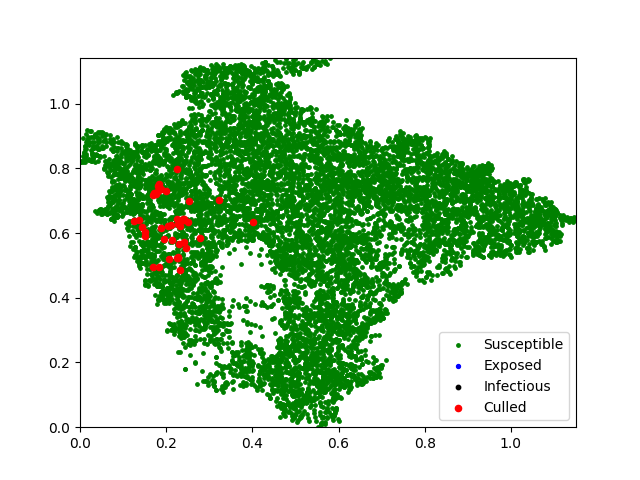

--- 112.45366191864014 seconds ---


In [131]:
#%matplotlib notebook

start_time = time.time()

fig = plt.figure()
ax = fig.add_subplot(111)
plt.ion

fig.show()
fig.canvas.draw()

while sum(I == 1) + sum(I == 2) > 0:

#Calculate transmission rate

    t = t + 1
    #print("Day", t, "Exposed", sum(I == 1), "Infected", sum(I == 2), "Culled", sum(I == 3))

    beta = np.zeros(N)
    for j in range(N):
        beta[j] = beta1[j]*(np.sum((zeta*(cattle[I == 2]**chi) + sheep[I == 2]**chi)*K[I == 2, j]))   

#Calculate probability of infection
    
    prob_inf = 1 - np.exp(-beta)
    
#Infect if probability is less that a uniform sample

    unif = np.random.uniform(0, 1, N)

    for i in range(0,N):
        if (unif[i] <= prob_inf[i] and I[i] == 0):
            I[i] =  1
            su = sum(I != 0)
            A[su-1, ] = [i, t, s[i], r[i]]
            #print("Farm", i, "Day", t)
            
#Update states
        
    inf = A[:,0][A[:,1] + A[:,2] == t] #Move to I state once latent period is over
    I[inf.astype(np.int64)] = 2
    rem = A[:,0][A[:,1] + A[:,2] + A[:,3] == t] #Move to R state once infectious period is over
    I[rem.astype(np.int64)] = 3
    out = sum(output[:,1] != 0)
    
#Store output

    if len(rem) > 0:
        for i in range(0,len(rem)):
            output[out + i,] = [rem[i], t - A[i,2] - A[i,3], xcoord[rem.astype(np.int64)[i]], ycoord[rem.astype(np.int64)[i]], cattle[rem.astype(np.int64)[i]], sheep[rem.astype(np.int64)[i]]]
     
    culledind = [i for i in range(np.size(I)) if I[i]==3]
    infectind = [i for i in range(np.size(I)) if I[i]==2]
    exposedind = [i for i in range(np.size(I)) if I[i]==1]
    susceptind = [i for i in range(np.size(I)) if I[i]==0]
    
    xculledplot = xinput[culledind]
    yculledplot = yinput[culledind]
    xinfectplot = xinput[infectind]
    yinfectplot = yinput[infectind]
    xexposedplot = xinput[exposedind]
    yexposedplot = yinput[exposedind]
    xsusceptplot = xinput[susceptind]
    ysusceptplot = yinput[susceptind]
    
    ax.clear()
    ax.scatter(xsusceptplot, ysusceptplot, c='g', marker='o', s=6, label='Susceptible')
    ax.scatter(xexposedplot, yexposedplot, c='b', marker='o', s=8, label='Exposed')
    ax.scatter(xinfectplot, yinfectplot, c='k', marker='o', s=10, label='Infectious')
    ax.scatter(xculledplot, yculledplot, c='r', marker='o', s=20, label='Culled')
    ax.axis([0, sizex, 0, sizey])
    ax.legend()
    fig.canvas.draw()

print("--- %s seconds ---" % (time.time() - start_time))


In [132]:
cattle[I == 2]

array([], dtype=int64)

In [133]:
np.random.randint(0, N)

8978

In [54]:
unif = np.random.uniform(0, 1, N)
print(unif)

[  9.17543035e-02   3.45386412e-01   5.54248060e-01   8.53648398e-01
   6.50145738e-01   8.42076232e-01   6.58869151e-01   5.55336887e-02
   2.31394826e-02   1.31547823e-01   4.49295628e-02   3.79088374e-01
   8.12289612e-02   5.86275020e-01   1.89427632e-01   3.56540826e-01
   7.35619929e-02   5.76949890e-03   6.97067202e-01   2.15001955e-01
   8.72017279e-01   5.56313125e-01   8.94989821e-01   3.66650654e-01
   2.78612074e-01   8.40489153e-01   3.48322802e-01   8.64033256e-01
   8.99122459e-01   7.11429609e-01   7.48856490e-01   1.97605771e-01
   9.42405109e-01   5.31139479e-01   5.13823779e-01   9.56073430e-01
   6.18646670e-01   5.83625574e-01   2.72071654e-01   9.60683302e-01
   6.86248252e-01   4.45102085e-01   5.20468256e-01   4.76462521e-01
   9.67914820e-01   2.82957311e-01   9.41230643e-03   5.90884376e-02
   9.69280636e-01   2.01251052e-01   1.12011770e-01   3.85836913e-01
   8.93802645e-01   3.40139818e-01   4.44652408e-01   9.64645955e-01
   5.92233898e-01   8.30678189e-01